## Example input
```
k: #particle name
  corr_file: "D200_rebin10_k0_fit.dat" #fit data points
  tmin_fits:
    single-exp: "D200_rebin10_k0_1exp.dat" #tmin fits
    double-exp: "D200_rebin10_k0_2exp.dat"
    geometric: "D200_rebin10_k0_geom.dat"
  tmin: 8 #final fit tmin
  tmax: 25 #all fit tmaxs
  fit_choice: "double-exp" #final fit form (in current setup, must be double-exp)
  energy: 0.156382648233 #final fit energy
  amp: 609.718319246 #final fit amp
  cont_energy: 0.529576864862 #final fit contamination energy
  cont_rat: 0.376768393109  #final fit contamination amp
  chisqrdof: 1.45 #final fit quality
```

In [1]:
import numpy as np
import h5py
import os, sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import yaml
import argparse

sys.path.append('../')
import utils
import settings
plt.style.use('../spectrum.mplstyle')
eff = r"\textup{eff}"

In [2]:
def double(t, A, E, R, D):
    return A*np.exp(-E*t)*(1.0+R*np.exp(-D*D*t))
def dtdouble(t, A, E, R, D):
    return -E*A*np.exp(-E*t)*(1.0+R*np.exp(-D*D*t))+A*np.exp(-E*t)*(-D*D*R*np.exp(-D*D*t))
def eff(t, A, E, R, D):
    return -dtdouble(t, A, E, R, D)/double(t, A, E, R, D)

In [3]:
with open('D200_rest_mass_info.yml', 'r') as file:
    data_info = yaml.load(file, Loader=yaml.FullLoader)

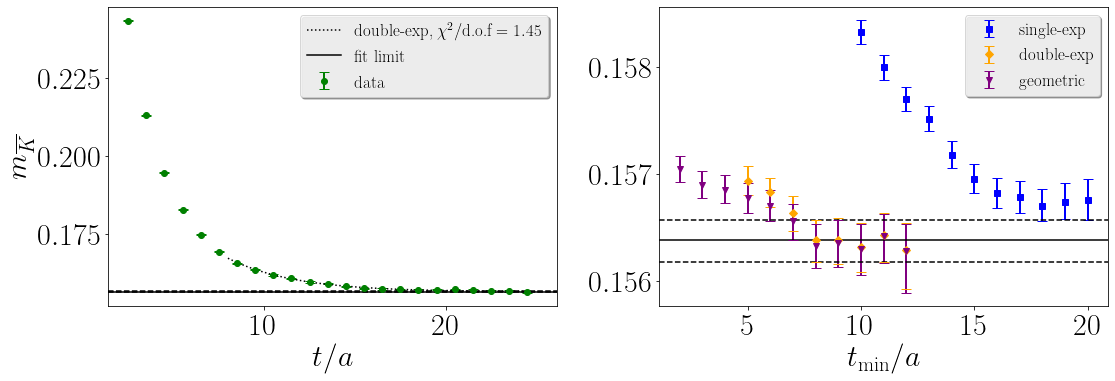

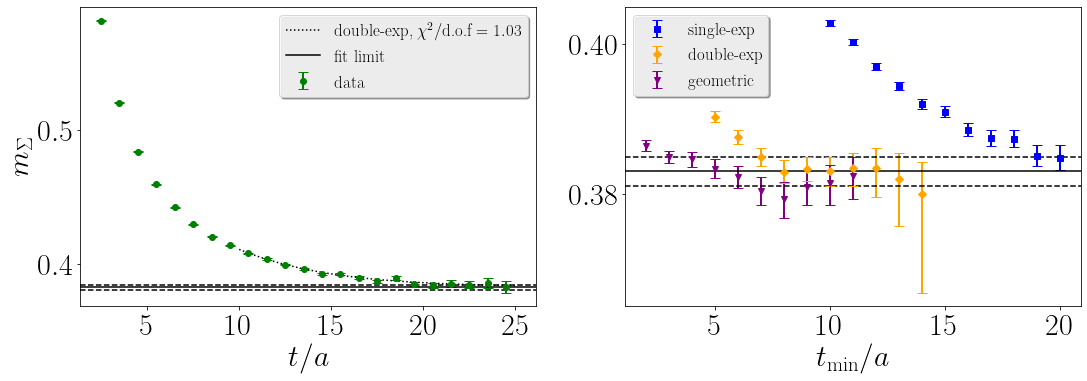

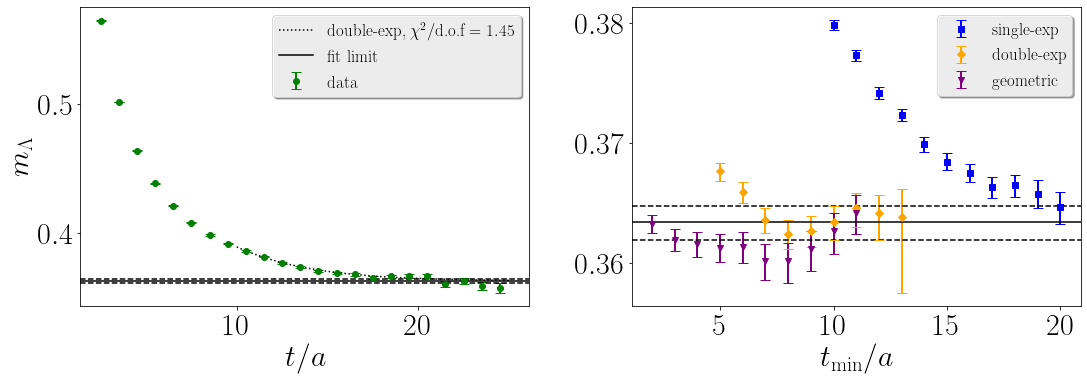

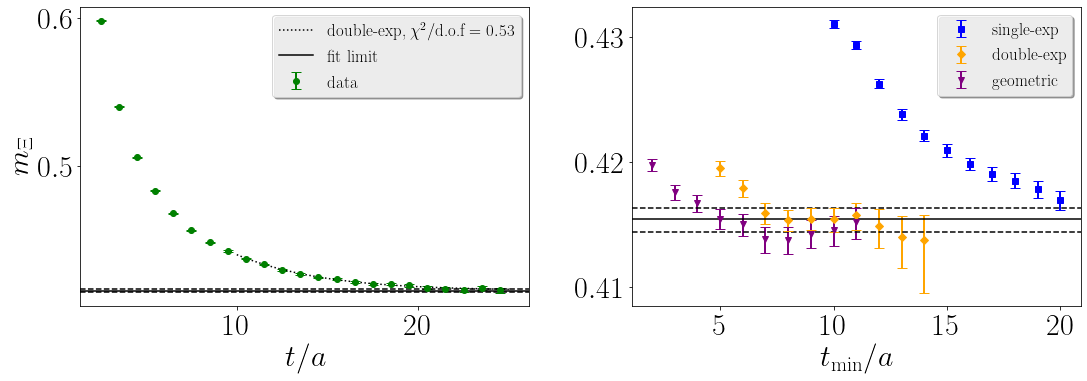

In [5]:
for data in data_info.keys():
    f, (ax1, ax2) = plt.subplots(1,2)
    f.set_figwidth(16)
    f.set_figheight(6)
    ax1.clear()
    ax2.clear()
    corr_data = pd.read_csv(os.path.join("D200rebin10", data_info[data]["corr_file"])," ",header=None)
    ax1.errorbar( corr_data[0], corr_data[1],corr_data[2], label="data",  color=settings.colors[0], marker=settings.markers[0], linewidth=0.0, elinewidth=2.0, capsize=5.0 )
    
    x=np.linspace(data_info[data]["tmin"],data_info[data]["tmax"],200)
    fit_func = eff(x, data_info[data]["amp"],data_info[data]["energy"],data_info[data]["cont_rat"],data_info[data]["cont_energy"])
    ax1.plot(x, fit_func, color = "black", ls = "dotted", label=rf"{data_info[data]['fit_choice']}, $\chi^2/\textup{{d.o.f}}={data_info[data]['chisqrdof']}$")
    
    i=1
    for label in data_info[data]["tmin_fits"].keys():
        tmin_data = pd.read_csv(os.path.join("D200rebin10", data_info[data]["tmin_fits"][label])," ",header=None)
        
        if label==data_info[data]["fit_choice"]:
            index = np.where(tmin_data[0]==data_info[data]["tmin"])[0][0]
            ax2.axhline(tmin_data[1][index], color="black")
            ax2.axhline(tmin_data[1][index]+tmin_data[2][index], color="black",ls="--")
            ax2.axhline(tmin_data[1][index]-tmin_data[3][index], color="black",ls="--")
            ax1.axhline(tmin_data[1][index], color="black",label="fit limit")
            ax1.axhline(tmin_data[1][index]+tmin_data[2][index], color="black",ls="--")
            ax1.axhline(tmin_data[1][index]-tmin_data[3][index], color="black",ls="--")
        
        ax2.errorbar( tmin_data[0], tmin_data[1],[tmin_data[3],tmin_data[2]], label=label,  color=settings.colors[i], marker=settings.markers[i], linewidth=0.0, elinewidth=2.0, capsize=5.0 )
        i+=1
        
    
    ax1.set_xlabel("$t/a$")
#     if "label" in data_info[data].keys():
#         ax1.set_ylabel(f"$m_{{{data_info[data]['label']}}}$")
#     else:
    ax1.set_ylabel(f"$m_{{{settings.latex_format[data].replace('$','')}}}$")
        
    ax2.set_xlabel(r"$t_{\textup{min}}/a$")
#     ax2.set_ylabel("$E_{eff}(t)$")
    ax1.legend()
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join("D200rebin10", data+"_rest_mass.png"))
    plt.savefig(os.path.join("D200rebin10", data+"_rest_mass.pdf"))
